In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import json
import os
import cv2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations as A
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Configuration
class Config:
    IMAGE_HEIGHT = 512
    IMAGE_WIDTH = 512
    NUM_CLASSES = 2  # background + building
    BATCH_SIZE = 4
    EPOCHS = 50
    LEARNING_RATE = 1e-4
    IMAGES_DIR = "/content/drive/MyDrive/Autonomous Drone/Building Dataset/Combined Data"  # Directory containing building images
    ANNOTATIONS_FILE = "/content/drive/MyDrive/Autonomous Drone/Building Dataset/training_data_207.json"  # VIA annotation file
    MODEL_SAVE_PATH = "/content/drive/MyDrive/Autonomous Drone/deeplabv3_building_model.h5"
    VALIDATION_SPLIT = 0.2

config = Config()

def load_via_annotations(annotations_file):
    """Load VIA annotations from JSON file"""
    with open(annotations_file, 'r') as f:
        annotations = json.load(f)
    return annotations

def polygon_to_mask(polygon_points, image_shape):
    """Convert polygon points to binary mask"""
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    if len(polygon_points) > 0:
        # Convert to format expected by fillPoly
        pts = np.array(polygon_points, dtype=np.int32)
        cv2.fillPoly(mask, [pts], 1)
    return mask

def parse_via_annotations(annotations, images_dir):
    """Parse VIA annotations and create image-mask pairs"""
    image_paths = []
    mask_data = []

    # Check if the annotations have the VIA metadata structure
    if '_via_img_metadata' in annotations:
        img_metadata = annotations['_via_img_metadata']

        for img_id, img_data in img_metadata.items():
            if 'filename' in img_data:
                filename = img_data['filename']
                image_path = os.path.join(images_dir, filename)

                if os.path.exists(image_path):
                    # Load image to get dimensions
                    image = cv2.imread(image_path)
                    if image is None:
                        print(f"Warning: Could not load image {image_path}")
                        continue

                    height, width = image.shape[:2]

                    # Create mask from polygons
                    mask = np.zeros((height, width), dtype=np.uint8)

                    if 'regions' in img_data:
                        for region in img_data['regions']:
                            if 'shape_attributes' in region:
                                shape_attrs = region['shape_attributes']
                                if shape_attrs['name'] == 'polygon':
                                    # Extract polygon points
                                    x_points = shape_attrs['all_points_x']
                                    y_points = shape_attrs['all_points_y']

                                    polygon_points = list(zip(x_points, y_points))
                                    region_mask = polygon_to_mask(polygon_points, (height, width))
                                    mask = np.maximum(mask, region_mask)
                                elif shape_attrs['name'] == 'rect':
                                    x = shape_attrs['x']
                                    y = shape_attrs['y']
                                    w = shape_attrs['width']
                                    h = shape_attrs['height']

                                    top_left = (x, y)
                                    bottom_right = (x + w, y + h)

                                    cv2.rectangle(mask, top_left, bottom_right, color=1, thickness=-1)

                                else:
                                    print(f"Warning: Unsupported shape type: {shape_attrs['name']}")

                    image_paths.append(image_path)
                    mask_data.append(mask)
                    print(f"Processed: {filename} with {len(img_data.get('regions', []))} regions")
                else:
                    print(f"Warning: Image not found at {image_path}")
    else:
        print("Error: Invalid VIA annotations format")

    return image_paths, mask_data

def create_augmentation_pipeline():
    """Create augmentation pipeline"""
    return A.Compose([
        # Remove RandomResizedCrop since we're handling aspect ratio with padding
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.RandomGamma(p=0.2),
        A.GaussNoise(p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.3),
    ])

def resize_with_padding(image, mask, target_size):
    """Resize image and mask with padding to maintain aspect ratio"""
    h, w = image.shape[:2]
    target_h, target_w = target_size

    # Calculate scaling factor to fit the image within target size
    scale = min(target_w / w, target_h / h)

    # Calculate new dimensions
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Resize image and mask
    image_resized = cv2.resize(image, (new_w, new_h))
    mask_resized = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    # Calculate padding
    pad_w = target_w - new_w
    pad_h = target_h - new_h

    # Pad evenly on both sides
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    # Apply padding
    image_padded = cv2.copyMakeBorder(
        image_resized, pad_top, pad_bottom, pad_left, pad_right,
        cv2.BORDER_CONSTANT, value=[0, 0, 0]  # Black padding
    )

    mask_padded = cv2.copyMakeBorder(
        mask_resized, pad_top, pad_bottom, pad_left, pad_right,
        cv2.BORDER_CONSTANT, value=0  # Background class padding
    )

    return image_padded, mask_padded

def preprocess_image(image_path, mask, augment=False):
    """Preprocess image and mask"""
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize with padding to maintain aspect ratio
    image, mask = resize_with_padding(image, mask, (config.IMAGE_HEIGHT, config.IMAGE_WIDTH))

    # Apply augmentations
    if augment:
        aug_pipeline = create_augmentation_pipeline()
        augmented = aug_pipeline(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']

    # Normalize image
    image = image.astype(np.float32) / 255.0

    # Convert mask to categorical
    mask = tf.keras.utils.to_categorical(mask, num_classes=config.NUM_CLASSES)

    return image, mask

class DataGenerator(tf.keras.utils.Sequence):
    """Data generator for training"""
    def __init__(self, image_paths, masks, batch_size, augment=False):
        self.image_paths = image_paths
        self.masks = masks
        self.batch_size = batch_size
        self.augment = augment
        self.indices = np.arange(len(image_paths))

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_masks = []

        for i in batch_indices:
            image, mask = preprocess_image(self.image_paths[i], self.masks[i], self.augment)
            batch_images.append(image)
            batch_masks.append(mask)

        return np.array(batch_images), np.array(batch_masks)

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

def aspp_block(x, filters, rate):
    """Atrous Spatial Pyramid Pooling block"""
    # 1x1 convolution
    x1 = Conv2D(filters, 1, padding='same', activation='relu')(x)

    # 3x3 convolution with different dilation rates
    x2 = Conv2D(filters, 3, padding='same', dilation_rate=rate, activation='relu')(x)

    return x2


In [ ]:
# Load Data

print("Loading annotations...")
annotations = load_via_annotations(config.ANNOTATIONS_FILE)

print("Parsing annotations...")

image_paths, masks = parse_via_annotations(annotations, config.IMAGES_DIR)

print(f"Found {len(image_paths)} images with annotations")


Loading annotations...
Parsing annotations...
Processed: 0321mariagstfrancis2.jpg with 1 regions
Processed: 03a_CO_UCLA-La-Kretz_Photo-KimRodgers_15.jpg with 1 regions
Processed: 1.2904_S_Washington_St__Seattle_Large-7HHaug_gao9km.jpg with 1 regions
Processed: 20191209_OldOrangeCoCourthouseSantaAnaCA2.jpg with 1 regions
Processed: 20200625-3.jpg with 1 regions
Processed: 25344_7_0.jpg with 1 regions
Processed: 360_F_256694284_XkhQFaJ42Y64iEcqmHsjAGvSfdlA6K2T.jpg with 1 regions
Processed: 400IS_1200x600.jpg with 1 regions
Processed: 4378.jpg with 1 regions
Processed: 50-story-tower-just-approved-for-downtown-los-angeles-v0-pcjhcoa9zc9d1.jpg with 1 regions
Processed: 5601Fishers.jpg with 1 regions
Processed: 8383041759_82f1d321d0_b.jpg with 1 regions
Processed: 84f6eb4bb591b212911d8e8dbbbb4fcce-f3588052721rd-w480_h360.jpg with 1 regions
Processed: 888-N-Main-St-Santa-Ana-CA-Building-1-HighDefinition-1.jpg with 1 regions
Processed: 8e6407ec06a346b4b515022267f0f051e-f2132370260rd-w480_h360

Image 0: /content/drive/MyDrive/Autonomous Drone/Building Dataset/Combined Data/0321mariagstfrancis2.jpg
Image 1: /content/drive/MyDrive/Autonomous Drone/Building Dataset/Combined Data/03a_CO_UCLA-La-Kretz_Photo-KimRodgers_15.jpg
Image 2: /content/drive/MyDrive/Autonomous Drone/Building Dataset/Combined Data/1.2904_S_Washington_St__Seattle_Large-7HHaug_gao9km.jpg
Image 3: /content/drive/MyDrive/Autonomous Drone/Building Dataset/Combined Data/20191209_OldOrangeCoCourthouseSantaAnaCA2.jpg
Image 4: /content/drive/MyDrive/Autonomous Drone/Building Dataset/Combined Data/20200625-3.jpg


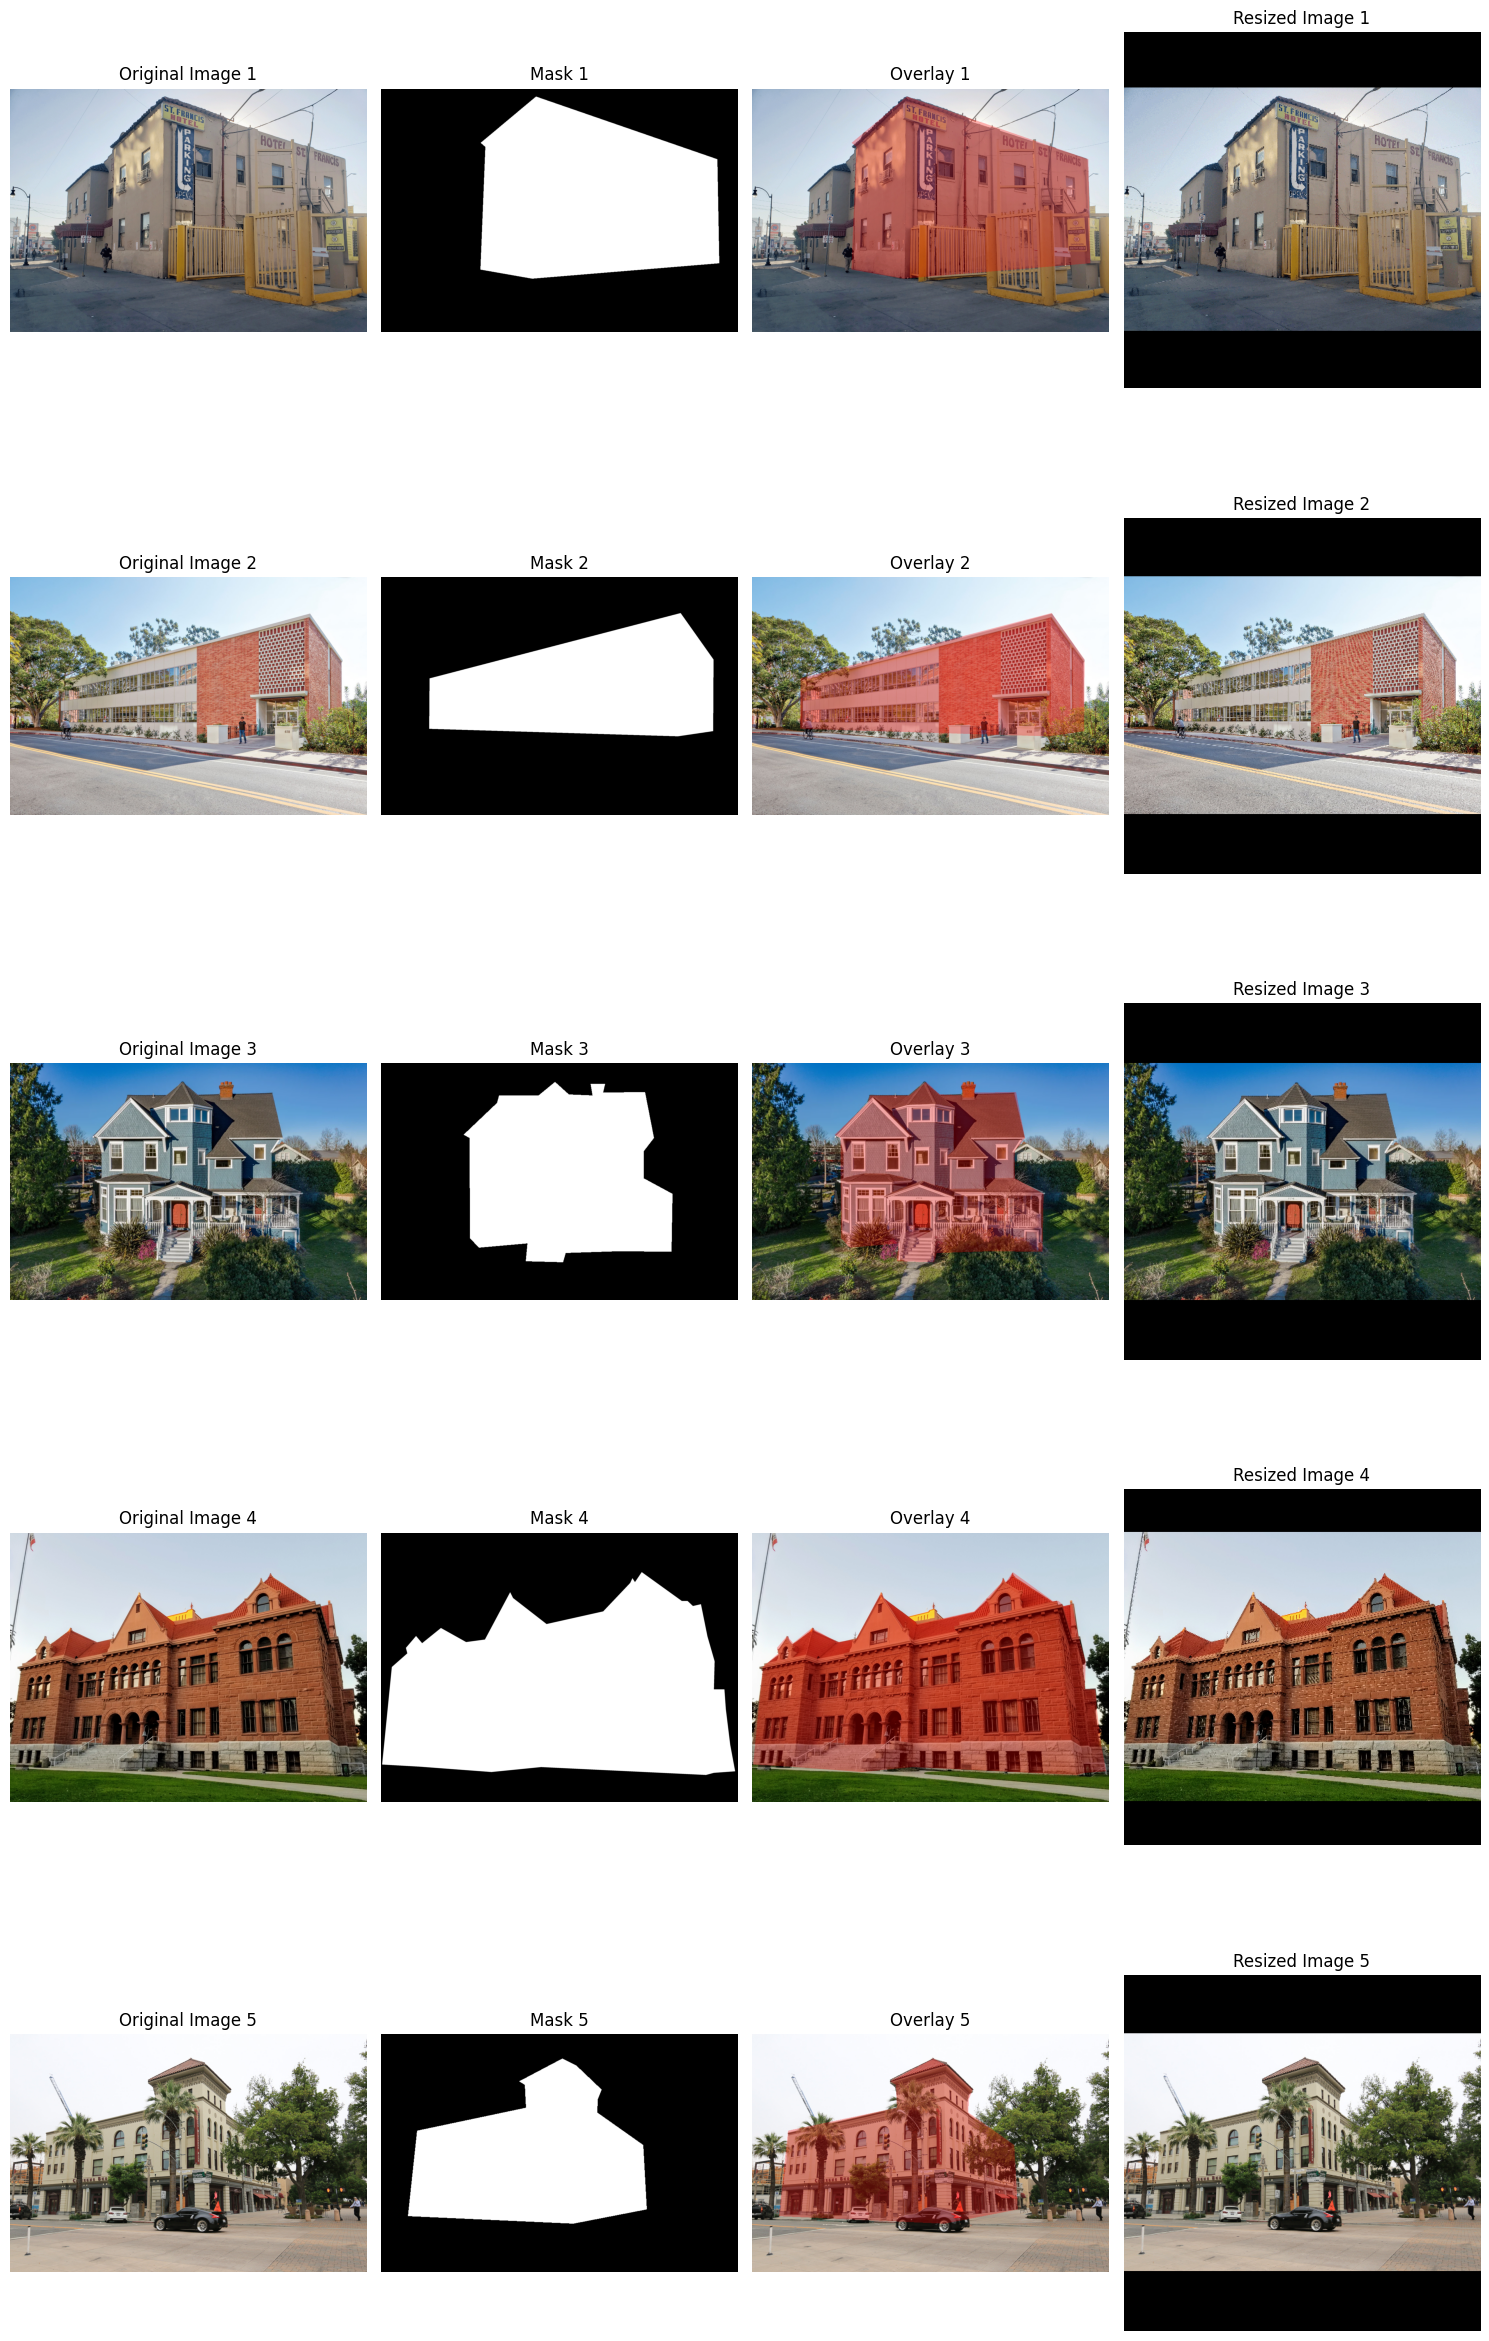

In [ ]:
def visualize_masks(image_paths, mask_data, num_samples=3):
    """Visualize original images with their corresponding masks"""
    num_samples = min(num_samples, len(image_paths))

    fig, axes = plt.subplots(num_samples, 4, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        # Load and convert image from BGR to RGB
        print(f"Image {i}: {image_paths[i]}")
        image = cv2.imread(image_paths[i])
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = mask_data[i]

        # Create overlay
        overlay = image_rgb.copy()
        overlay[mask > 0] = [255, 0, 0]  # Red color for masked regions
        blended = cv2.addWeighted(image_rgb, 0.7, overlay, 0.3, 0)

        resize_padded = resize_with_padding(image_rgb, mask, (config.IMAGE_HEIGHT, config.IMAGE_WIDTH))

        # Plot original image
        axes[i, 0].imshow(image_rgb)
        axes[i, 0].set_title(f'Original Image {i+1}')
        axes[i, 0].axis('off')

        # Plot mask
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f'Mask {i+1}')
        axes[i, 1].axis('off')

        # Plot overlay
        axes[i, 2].imshow(blended)
        axes[i, 2].set_title(f'Overlay {i+1}')
        axes[i, 2].axis('off')

        axes[i,3].imshow(resize_padded[0])
        axes[i,3].set_title(f'Resized Image {i+1}')
        axes[i,3].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize first 3 images
visualize_masks(image_paths, masks, num_samples=5)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.saving import register_keras_serializable

@register_keras_serializable()
def resize_tensor(inputs):
    tensor_to_resize, reference_tensor = inputs
    # Cast to float32 to ensure consistency
    tensor_to_resize = tf.cast(tensor_to_resize, tf.float32)
    reference_shape = tf.shape(reference_tensor)[1:3]
    # return tf.image.resize(tensor_to_resize, reference_shape)
    return tf.image.resize(tensor_to_resize, reference_shape)

# Set default dtype to float32 at the beginning
tf.keras.backend.set_floatx('float32')

def aspp_block(inputs, filters, rate):
    """ASPP block for DeepLabV3"""
    if rate == 1:
        conv = Conv2D(filters, 1, padding='same', activation='relu', dtype='float32')(inputs)
    else:
        conv = Conv2D(filters, 3, padding='same', dilation_rate=rate, activation='relu', dtype='float32')(inputs)
    conv = BatchNormalization(dtype='float32')(conv)
    return conv

def create_deeplabv3_model(input_shape, num_classes):
    """Create DeepLabV3 model"""
    # Ensure input tensor is float32
    inputs = Input(shape=input_shape, dtype='float32')

    # Backbone - ResNet50
    backbone = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # Get features from different stages
    low_level_features = backbone.get_layer('conv2_block3_out').output  # 1/4 resolution
    high_level_features = backbone.output  # 1/32 resolution

    # ASPP (Atrous Spatial Pyramid Pooling)
    aspp1 = aspp_block(high_level_features, 256, 1)
    aspp2 = aspp_block(high_level_features, 256, 6)
    aspp3 = aspp_block(high_level_features, 256, 12)
    aspp4 = aspp_block(high_level_features, 256, 18)

    # Global Average Pooling
    gap = GlobalAveragePooling2D(dtype='float32')(high_level_features)
    gap = Reshape((1, 1, 2048))(gap)
    gap = Conv2D(256, 1, activation='relu', dtype='float32')(gap)

    # Get the actual shape of high_level_features for upsampling

    gap = Lambda(resize_tensor)([gap, high_level_features])

    # Concatenate ASPP features
    aspp_concat = Concatenate()([aspp1, aspp2, aspp3, aspp4, gap])
    aspp_concat = Conv2D(256, 1, activation='relu', dtype='float32')(aspp_concat)
    aspp_concat = BatchNormalization(dtype='float32')(aspp_concat)
    aspp_concat = Dropout(0.1)(aspp_concat)

    # Upsample ASPP output to match low-level features size
    # Low-level features are at 1/4 resolution, high-level at 1/32, so we need 8x upsampling
    decoder_output = UpSampling2D(size=(8, 8), interpolation='bilinear')(aspp_concat)

    # Process low-level features
    low_level_features = Conv2D(48, 1, activation='relu', dtype='float32')(low_level_features)
    low_level_features = BatchNormalization(dtype='float32')(low_level_features)

    # Ensure both tensors have the same spatial dimensions before concatenation
    decoder_output = Lambda(resize_tensor)([decoder_output, low_level_features])

    # Concatenate with low-level features
    decoder_concat = Concatenate()([decoder_output, low_level_features])
    decoder_concat = Conv2D(256, 3, padding='same', activation='relu', dtype='float32')(decoder_concat)
    decoder_concat = BatchNormalization(dtype='float32')(decoder_concat)
    decoder_concat = Dropout(0.1)(decoder_concat)

    decoder_concat = Conv2D(256, 3, padding='same', activation='relu', dtype='float32')(decoder_concat)
    decoder_concat = BatchNormalization(dtype='float32')(decoder_concat)
    decoder_concat = Dropout(0.1)(decoder_concat)

    # Final upsampling to original resolution (4x upsampling from 1/4 resolution)
    outputs = UpSampling2D(size=(4, 4), interpolation='bilinear')(decoder_concat)
    outputs = Conv2D(num_classes, 1, activation='softmax', dtype='float32')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model


def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Dice coefficient for segmentation"""
    # Ensure both tensors are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """Dice loss for segmentation"""
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    """Combined loss: Categorical crossentropy + Dice loss"""
    # Ensure both tensors are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    dice_loss_val = dice_loss(y_true, y_pred)
    return ce_loss + dice_loss_val

def iou_score(y_true, y_pred):
    """IoU score for segmentation"""
    # Ensure both tensors are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return intersection / (union + 1e-6)


# Train Model

In [ ]:

# Split data
train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, masks, test_size=config.VALIDATION_SPLIT, random_state=42
)

print(f"Training samples: {len(train_images)}")
print(f"Validation samples: {len(val_images)}")

# Create data generators
train_generator = DataGenerator(train_images, train_masks, config.BATCH_SIZE, augment=True)
val_generator = DataGenerator(val_images, val_masks, config.BATCH_SIZE, augment=False)

# Create model
print("Creating DeepLabV3 model...")
model = create_deeplabv3_model(
    (config.IMAGE_HEIGHT, config.IMAGE_WIDTH, 3),
    config.NUM_CLASSES
)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=config.LEARNING_RATE),
    loss=combined_loss,
    metrics=['accuracy', dice_coefficient, iou_score]
)

# Callbacks
callbacks = [
    ModelCheckpoint(
        config.MODEL_SAVE_PATH,
        monitor='val_dice_coefficient',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_dice_coefficient',
        patience=15,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_dice_coefficient',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        mode='max',
        verbose=1
    )
]

# Train model
print("Starting training...")
history = model.fit(
    train_generator,
    epochs=config.EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)


Training samples: 165
Validation samples: 42
Creating DeepLabV3 model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Starting training...
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.8053 - dice_coefficient: 0.7647 - iou_score: 0.6320 - loss: 0.7538
Epoch 1: val_dice_coefficient improved from -inf to 0.42821, saving model to /content/drive/MyDrive/Autonomous Drone/deeplabv3_building_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 135s 922ms/step - accuracy: 0.8069 - dice_coefficient: 0.7664 - iou_score: 0.6343 - loss: 0.7488 - val_accuracy: 0.3797 - val_dice_coefficient: 0.4282 - val_iou_score: 0.2732 - val_loss: 2.1830 - learning_rate: 1.0000e-04
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.9283 - dice_coefficient: 0.9085 - iou_score: 0.8329 - loss: 0.3090
Epoch 2: val_dice_coefficient improved from 0.42821 to 0.68907, saving model to /content/drive/MyDrive/Autonomous Drone/deeplabv3_building_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 915ms/step - accuracy: 0.9285 - dice_coefficient: 0.9086 - iou_score: 0.8331 - loss: 0.3087 - val_accuracy: 0.7814 - val_dice_coefficient: 0.6891 - val_iou_score: 0.5265 - val_loss: 0.7991 - learning_rate: 1.0000e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.9455 - dice_coefficient: 0.9231 - iou_score: 0.8577 - loss: 0.2407
Epoch 3: val_dice_coefficient improved from 0.68907 to 0.74871, saving model to /content/drive/MyDrive/Autonomous Drone/deeplabv3_building_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9455 - dice_coefficient: 0.9232 - iou_score: 0.8579 - loss: 0.2404 - val_accuracy: 0.7725 - val_dice_coefficient: 0.7487 - val_iou_score: 0.6008 - val_loss: 0.9505 - learning_rate: 1.0000e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.9505 - dice_coefficient: 0.9316 - iou_score: 0.8729 - loss: 0.2190
Epoch 4: val_dice_coefficient improved from 0.74871 to 0.75929, saving model to /content/drive/MyDrive/Autonomous Drone/deeplabv3_building_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9505 - dice_coefficient: 0.9317 - iou_score: 0.8730 - loss: 0.2187 - val_accuracy: 0.7683 - val_dice_coefficient: 0.7593 - val_iou_score: 0.6143 - val_loss: 0.8790 - learning_rate: 1.0000e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.9526 - dice_coefficient: 0.9384 - iou_score: 0.8848 - loss: 0.1875
Epoch 5: val_dice_coefficient improved from 0.75929 to 0.76794, saving model to /content/drive/MyDrive/Autonomous Drone/deeplabv3_building_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9527 - dice_coefficient: 0.9384 - iou_score: 0.8849 - loss: 0.1874 - val_accuracy: 0.7737 - val_dice_coefficient: 0.7679 - val_iou_score: 0.6247 - val_loss: 1.1254 - learning_rate: 1.0000e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.9661 - dice_coefficient: 0.9524 - iou_score: 0.9093 - loss: 0.1421
Epoch 6: val_dice_coefficient did not improve from 0.76794
41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 938ms/step - accuracy: 0.9661 - dice_coefficient: 0.9523 - iou_score: 0.9093 - loss: 0.1424 - val_accuracy: 0.7695 - val_dice_coefficient: 0.7673 - val_iou_score: 0.6253 - val_loss: 1.1909 - learning_rate: 1.0000e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.9687 - dice_coefficient: 0.9556 - iou_score: 0.9153 - loss: 0.1318
Epoch 7: val_dice_coefficient improved from 0.76794 to 0.76836, saving model to /content/drive/MyDrive/Autonomous Drone/deeplabv3_building_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9686 - dice_coefficient: 0.9556 - iou_score: 0.9153 - loss: 0.1319 - val_accuracy: 0.7700 - val_dice_coefficient: 0.7684 - val_iou_score: 0.6253 - val_loss: 1.0875 - learning_rate: 1.0000e-04
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.9691 - dice_coefficient: 0.9587 - iou_score: 0.9211 - loss: 0.1242
Epoch 8: val_dice_coefficient did not improve from 0.76836
41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 863ms/step - accuracy: 0.9691 - dice_coefficient: 0.9587 - iou_score: 0.9211 - loss: 0.1242 - val_accuracy: 0.7653 - val_dice_coefficient: 0.7659 - val_iou_score: 0.6231 - val_loss: 1.3077 - learning_rate: 1.0000e-04
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.9717 - dice_coefficient: 0.9597 - iou_score: 0.9232 - loss: 0.1269
Epoch 9: val_dice_coefficient did not improve from 0.76836
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 656ms/step - accuracy: 0.9717 - dice_coefficient: 0.9597 - iou_score: 0.9232 - loss: 0.1269 

41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 965ms/step - accuracy: 0.9774 - dice_coefficient: 0.9672 - iou_score: 0.9366 - loss: 0.0944 - val_accuracy: 0.7691 - val_dice_coefficient: 0.7710 - val_iou_score: 0.6293 - val_loss: 1.5119 - learning_rate: 1.0000e-04
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.9770 - dice_coefficient: 0.9685 - iou_score: 0.9390 - loss: 0.0923
Epoch 11: val_dice_coefficient improved from 0.77095 to 0.79304, saving model to /content/drive/MyDrive/Autonomous Drone/deeplabv3_building_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9770 - dice_coefficient: 0.9685 - iou_score: 0.9391 - loss: 0.0922 - val_accuracy: 0.7896 - val_dice_coefficient: 0.7930 - val_iou_score: 0.6604 - val_loss: 1.0588 - learning_rate: 1.0000e-04
Epoch 12/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.9773 - dice_coefficient: 0.9693 - iou_score: 0.9406 - loss: 0.0910
Epoch 12: val_dice_coefficient improved from 0.79304 to 0.83546, saving model to /content/drive/MyDrive/Autonomous Drone/deeplabv3_building_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9773 - dice_coefficient: 0.9693 - iou_score: 0.9405 - loss: 0.0911 - val_accuracy: 0.8349 - val_dice_coefficient: 0.8355 - val_iou_score: 0.7210 - val_loss: 0.7412 - learning_rate: 1.0000e-04
Epoch 13/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.9794 - dice_coefficient: 0.9710 - iou_score: 0.9437 - loss: 0.0849
Epoch 13: val_dice_coefficient improved from 0.83546 to 0.84704, saving model to /content/drive/MyDrive/Autonomous Drone/deeplabv3_building_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9794 - dice_coefficient: 0.9710 - iou_score: 0.9437 - loss: 0.0849 - val_accuracy: 0.8473 - val_dice_coefficient: 0.8470 - val_iou_score: 0.7379 - val_loss: 0.7678 - learning_rate: 1.0000e-04
Epoch 14/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.9794 - dice_coefficient: 0.9721 - iou_score: 0.9459 - loss: 0.0830
Epoch 14: val_dice_coefficient improved from 0.84704 to 0.85157, saving model to /content/drive/MyDrive/Autonomous Drone/deeplabv3_building_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9794 - dice_coefficient: 0.9721 - iou_score: 0.9460 - loss: 0.0829 - val_accuracy: 0.8530 - val_dice_coefficient: 0.8516 - val_iou_score: 0.7432 - val_loss: 0.6598 - learning_rate: 1.0000e-04
Epoch 15/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.9773 - dice_coefficient: 0.9697 - iou_score: 0.9415 - loss: 0.0900
Epoch 15: val_dice_coefficient improved from 0.85157 to 0.87613, saving model to /content/drive/MyDrive/Autonomous Drone/deeplabv3_building_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9774 - dice_coefficient: 0.9698 - iou_score: 0.9415 - loss: 0.0899 - val_accuracy: 0.8801 - val_dice_coefficient: 0.8761 - val_iou_score: 0.7814 - val_loss: 0.5144 - learning_rate: 1.0000e-04
Epoch 16/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.9806 - dice_coefficient: 0.9735 - iou_score: 0.9484 - loss: 0.0789
Epoch 16: val_dice_coefficient improved from 0.87613 to 0.91454, saving model to /content/drive/MyDrive/Autonomous Drone/deeplabv3_building_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9806 - dice_coefficient: 0.9734 - iou_score: 0.9484 - loss: 0.0790 - val_accuracy: 0.9206 - val_dice_coefficient: 0.9145 - val_iou_score: 0.8440 - val_loss: 0.3128 - learning_rate: 1.0000e-04
Epoch 17/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.9808 - dice_coefficient: 0.9739 - iou_score: 0.9492 - loss: 0.0766
Epoch 17: val_dice_coefficient improved from 0.91454 to 0.93122, saving model to /content/drive/MyDrive/Autonomous Drone/deeplabv3_building_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9807 - dice_coefficient: 0.9738 - iou_score: 0.9492 - loss: 0.0767 - val_accuracy: 0.9380 - val_dice_coefficient: 0.9312 - val_iou_score: 0.8719 - val_loss: 0.2616 - learning_rate: 1.0000e-04
Epoch 18/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.9826 - dice_coefficient: 0.9762 - iou_score: 0.9536 - loss: 0.0708
Epoch 18: val_dice_coefficient did not improve from 0.93122
41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 863ms/step - accuracy: 0.9826 - dice_coefficient: 0.9761 - iou_score: 0.9535 - loss: 0.0710 - val_accuracy: 0.9246 - val_dice_coefficient: 0.9190 - val_iou_score: 0.8512 - val_loss: 0.3325 - learning_rate: 1.0000e-04
Epoch 19/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9814 - dice_coefficient: 0.9737 - iou_score: 0.9489 - loss: 0.0767
Epoch 19: val_dice_coefficient improved from 0.93122 to 0.93298, saving model to /content/drive/MyDrive/Autonomous Drone/deeplabv3_building_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 977ms/step - accuracy: 0.9813 - dice_coefficient: 0.9737 - iou_score: 0.9489 - loss: 0.0768 - val_accuracy: 0.9376 - val_dice_coefficient: 0.9330 - val_iou_score: 0.8752 - val_loss: 0.3033 - learning_rate: 1.0000e-04
Epoch 20/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.9803 - dice_coefficient: 0.9726 - iou_score: 0.9469 - loss: 0.0808
Epoch 20: val_dice_coefficient did not improve from 0.93298
41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 854ms/step - accuracy: 0.9803 - dice_coefficient: 0.9726 - iou_score: 0.9470 - loss: 0.0807 - val_accuracy: 0.9385 - val_dice_coefficient: 0.9329 - val_iou_score: 0.8749 - val_loss: 0.2666 - learning_rate: 1.0000e-04
Epoch 21/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9822 - dice_coefficient: 0.9756 - iou_score: 0.9524 - loss: 0.0730
Epoch 21: val_dice_coefficient did not improve from 0.93298
41/41 ━━━━━━━━━━━━━━━━━━━━ 29s 715ms/step - accuracy: 0.9821 - dice_coefficient: 0.9755 - iou_score: 0.9524 - loss: 

41/41 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9811 - dice_coefficient: 0.9721 - iou_score: 0.9459 - loss: 0.0796 - val_accuracy: 0.9559 - val_dice_coefficient: 0.9502 - val_iou_score: 0.9055 - val_loss: 0.2274 - learning_rate: 1.0000e-04
Epoch 23/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.9848 - dice_coefficient: 0.9789 - iou_score: 0.9588 - loss: 0.0606
Epoch 23: val_dice_coefficient improved from 0.95023 to 0.95234, saving model to /content/drive/MyDrive/Autonomous Drone/deeplabv3_building_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9848 - dice_coefficient: 0.9789 - iou_score: 0.9587 - loss: 0.0607 - val_accuracy: 0.9578 - val_dice_coefficient: 0.9523 - val_iou_score: 0.9094 - val_loss: 0.2040 - learning_rate: 1.0000e-04
Epoch 24/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.9851 - dice_coefficient: 0.9798 - iou_score: 0.9604 - loss: 0.0594
Epoch 24: val_dice_coefficient improved from 0.95234 to 0.96097, saving model to /content/drive/MyDrive/Autonomous Drone/deeplabv3_building_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9851 - dice_coefficient: 0.9798 - iou_score: 0.9604 - loss: 0.0594 - val_accuracy: 0.9658 - val_dice_coefficient: 0.9610 - val_iou_score: 0.9252 - val_loss: 0.1762 - learning_rate: 1.0000e-04
Epoch 25/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.9834 - dice_coefficient: 0.9775 - iou_score: 0.9562 - loss: 0.0673
Epoch 25: val_dice_coefficient did not improve from 0.96097
41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 939ms/step - accuracy: 0.9835 - dice_coefficient: 0.9775 - iou_score: 0.9562 - loss: 0.0673 - val_accuracy: 0.9581 - val_dice_coefficient: 0.9535 - val_iou_score: 0.9121 - val_loss: 0.2082 - learning_rate: 1.0000e-04
Epoch 26/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.9838 - dice_coefficient: 0.9782 - iou_score: 0.9575 - loss: 0.0656
Epoch 26: val_dice_coefficient did not improve from 0.96097
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 641ms/step - accuracy: 0.9838 - dice_coefficient: 0.9782 - iou_score: 0.9575 - loss: 0.0

41/41 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9855 - dice_coefficient: 0.9799 - iou_score: 0.9606 - loss: 0.0596 - val_accuracy: 0.9655 - val_dice_coefficient: 0.9619 - val_iou_score: 0.9273 - val_loss: 0.1721 - learning_rate: 1.0000e-04
Epoch 33/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.9885 - dice_coefficient: 0.9844 - iou_score: 0.9694 - loss: 0.0458
Epoch 33: val_dice_coefficient did not improve from 0.96191
41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 847ms/step - accuracy: 0.9885 - dice_coefficient: 0.9844 - iou_score: 0.9693 - loss: 0.0460 - val_accuracy: 0.9611 - val_dice_coefficient: 0.9573 - val_iou_score: 0.9188 - val_loss: 0.1874 - learning_rate: 1.0000e-04
Epoch 34/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9892 - dice_coefficient: 0.9847 - iou_score: 0.9699 - loss: 0.0426
Epoch 34: val_dice_coefficient did not improve from 0.96191
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 646ms/step - accuracy: 0.9891 - dice_coefficient: 0.9847 - iou_score: 0.9699 - loss: 0.0

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 518, 518,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 256, 256,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 256, 256,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 256, 256,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 258, 258,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 128, 128,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 128, 128,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 128, 128,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 128, 128,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 128, 128,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 128, 128,  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 128, 128,  │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 128, 128,  │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 128, 128,  │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 128, 128,  │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 128, 128,  │      1,024 │ conv2_block1_3_c

 Total params: 121,183,128 (462.28 MB)

 Trainable params: 40,375,442 (154.02 MB)

 Non-trainable params: 56,800 (221.88 KB)

 Optimizer params: 80,750,886 (308.04 MB)

In [ ]:

def plot_training_history(history):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    # Dice Coefficient
    axes[1, 0].plot(history.history['dice_coefficient'], label='Training Dice')
    axes[1, 0].plot(history.history['val_dice_coefficient'], label='Validation Dice')
    axes[1, 0].set_title('Dice Coefficient')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Dice Coefficient')
    axes[1, 0].legend()

    # IoU Score
    axes[1, 1].plot(history.history['iou_score'], label='Training IoU')
    axes[1, 1].plot(history.history['val_iou_score'], label='Validation IoU')
    axes[1, 1].set_title('IoU Score')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('IoU Score')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def predict_on_new_image(model, image_path):
    """Predict building segmentation on a new image"""
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_shape = image.shape[:2]

    # Create a dummy mask for the resize_with_padding function
    dummy_mask = np.zeros(original_shape, dtype=np.uint8)

    # Resize with padding to maintain aspect ratio
    image_padded, _ = resize_with_padding(image, dummy_mask, (config.IMAGE_HEIGHT, config.IMAGE_WIDTH))

    # Normalize for model input and ensure float32
    image_normalized = image_padded.astype(np.float32) / 255.0
    image_batch = np.expand_dims(image_normalized, axis=0)

    # Predict
    prediction = model.predict(image_batch)
    predicted_mask = np.argmax(prediction[0], axis=-1)

    # Remove padding and resize back to original size
    predicted_mask = remove_padding_and_resize(predicted_mask, original_shape)

    return predicted_mask

def remove_padding_and_resize(padded_mask, original_shape):
    """Remove padding and resize mask back to original image size"""
    original_h, original_w = original_shape
    target_h, target_w = config.IMAGE_HEIGHT, config.IMAGE_WIDTH

    # Calculate the scale that was used during padding
    scale = min(target_w / original_w, target_h / original_h)

    # Calculate the actual image size after scaling (before padding)
    scaled_w = int(original_w * scale)
    scaled_h = int(original_h * scale)

    # Calculate padding that was added
    pad_w = target_w - scaled_w
    pad_h = target_h - scaled_h
    pad_top = pad_h // 2
    pad_left = pad_w // 2

    # Remove padding
    unpadded_mask = padded_mask[pad_top:pad_top + scaled_h, pad_left:pad_left + scaled_w]

    # Resize back to original size
    final_mask = cv2.resize(unpadded_mask.astype(np.uint8),
                           (original_w, original_h),
                           interpolation=cv2.INTER_NEAREST)

    return final_mask

# def visualize_prediction(image_path, predicted_mask):
#     """Visualize prediction results"""
#     # Load original image
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # Create visualization
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#     # Original image
#     axes[0].imshow(image)
#     axes[0].set_title('Original Image')
#     axes[0].axis('off')

#     # Predicted mask
#     axes[1].imshow(predicted_mask, cmap='gray')
#     axes[1].set_title('Predicted Mask')
#     axes[1].axis('off')

#     # Overlay
#     overlay = image.copy()
#     overlay[predicted_mask == 1] = [255, 0, 0]  # Red for buildings
#     blended = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)

#     axes[2].imshow(blended)
#     axes[2].set_title('Overlay')
#     axes[2].axis('off')

#     plt.tight_layout()
#     plt.show()


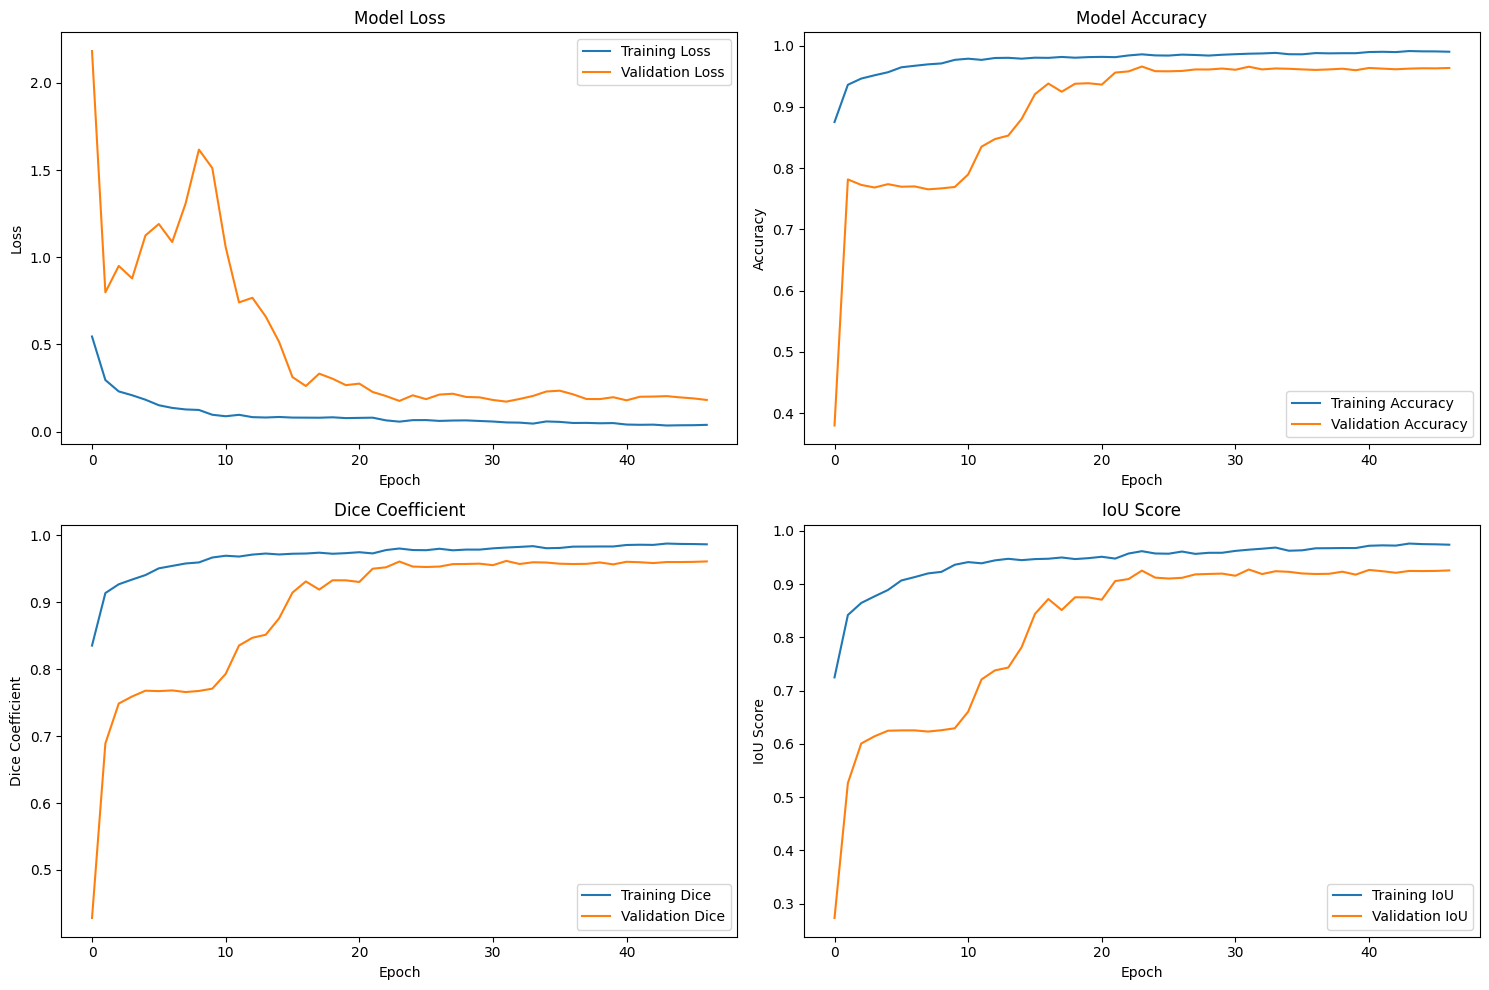

In [ ]:
plot_training_history(history)

In [ ]:
def visualize_predictions(model, dataset, save_dir="predictions", num_images=5):
    os.makedirs(save_dir, exist_ok=True)
    count = 0

    for batch in dataset:
        images, masks = batch
        preds = model.predict(images)
        preds = tf.argmax(preds, axis=-1).numpy()

        for i in range(images.shape[0]):
            if count >= num_images:
                return

            img = images[i]  # already a NumPy array
            print(img.shape)
            true_mask = masks[i].squeeze()  # already a NumPy array
            pred_mask = preds[i]

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(img)
            axs[0].set_title("Input Image")
            axs[0].axis("off")

            axs[1].imshow(np.argmax(true_mask, axis=-1), cmap="gray")
            # axs[1].imshow(true_mask, cmap="gray")
            axs[1].set_title("Ground Truth")
            axs[1].axis("off")

            # axs[2].imshow(pred_mask, cmap="gray")
            # axs[2].imshow(np.argmax(pred_mask, axis=-1), cmap="gray")
            # Ensure pred_mask is in the correct shape
            # If pred_mask is (1, H, W, num_classes), squeeze batch dim
            if pred_mask.ndim == 4:
                pred_mask = pred_mask[0]

            # If pred_mask is (H, W, num_classes), convert to (H, W)
            if pred_mask.ndim == 3:
                pred_mask = np.argmax(pred_mask, axis=-1)

            # Now pred_mask should be 2D
            axs[2].imshow(pred_mask, cmap="gray")



            axs[2].set_title("Predicted Mask")
            axs[2].axis("off")

            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, f"prediction_{count}.png"))
            plt.close()
            count += 1

In [ ]:
# new_image_path = "path/to/new/image.jpg"
# predicted_mask = predict_on_new_image(model, new_image_path)
# visualize_prediction(new_image_path, predicted_mask)


# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

visualization_path =  "/content/drive/MyDrive/Autonomous Drone/Visualizations"
visualize_predictions(model, val_generator, save_dir=visualization_path, num_images=40)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
